Random state = 3, noise = 0.18 for makemoons and random state for train test split = 12

In [1]:
import torch
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
import torch.nn as nn

class OptimizedDifferentiablePchip(nn.Module):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = nn.Parameter(y)
        self.n = len(x) - 1
        self.d = None  # To store precomputed derivatives

    def _compute_derivatives(self, y):
        dy = y[1:] - y[:-1]
        dx = self.x[1:] - self.x[:-1]
        slopes = dy / dx
        d = torch.zeros_like(y)
        for i in range(1, len(y) - 1):
            if slopes[i - 1] * slopes[i] > 0:
                w1 = 2 * dx[i] + dx[i - 1]
                w2 = dx[i] + 2 * dx[i - 1]
                d[i] = (w1 + w2) / (w1 / slopes[i - 1] + w2 / slopes[i])
        d[0] = slopes[0]
        d[-1] = slopes[-1]
        return d

    def update_derivatives(self):
        """Compute and store derivatives for the current y values."""
        self.d = self._compute_derivatives(self.y)

    def forward(self, t):
        if self.d is None:
            self.update_derivatives()  # Fallback in case not precomputed
        t = t.contiguous()
        idx = torch.clamp(torch.searchsorted(self.x, t) - 1, 0, self.n - 1)
        x0 = self.x[idx]
        x1 = self.x[idx + 1]
        y0 = self.y[idx]
        y1 = self.y[idx + 1]
        t_norm = (t - x0) / (x1 - x0)
        d0 = self.d[idx]
        d1 = self.d[idx + 1]
        t2 = t_norm * t_norm
        t3 = t2 * t_norm
        h00 = 2 * t3 - 3 * t2 + 1
        h10 = t3 - 2 * t2 + t_norm
        h01 = -2 * t3 + 3 * t2
        h11 = t3 - t2
        dx_segment = x1 - x0
        return h00 * y0 + h10 * dx_segment * d0 + h01 * y1 + h11 * dx_segment * d1

class OptimizedPyTorchGradientSMPA(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.05, epochs=100, random_state=7, verbose=False,
                 lambda_reg=0.0001, patience=10, decay_factor=0.9, min_learning_rate=1e-6,
                 n_control_points=6, device=None, track_history=False, optimizer_type='adam',
                 scheduler_type='reduce_on_plateau'):
        self.learning_rate = learning_rate
        self.initial_learning_rate = learning_rate
        self.epochs = epochs
        self.random_state = random_state
        self.verbose = verbose
        self.lambda_reg = lambda_reg
        self.patience = patience
        self.decay_factor = decay_factor
        self.min_learning_rate = min_learning_rate
        self.n_control_points = n_control_points
        self.device = device if device is not None else ('cuda' if torch.cuda.is_available() else 'cpu')
        self.track_history = track_history
        self.optimizer_type = optimizer_type
        self.scheduler_type = scheduler_type
        torch.manual_seed(random_state)
        np.random.seed(random_state)

    def _to_tensor(self, data, dtype=torch.float32):
        if isinstance(data, torch.Tensor):
            return data.to(self.device, dtype=dtype, non_blocking=True)
        return torch.tensor(data, dtype=dtype, device=self.device)

    def _calculate_class_means(self, X, y):
        mask_1 = y == 1
        self.m1 = torch.mean(X[mask_1], dim=0)
        self.m0 = torch.mean(X[~mask_1], dim=0)

    def _initialize_control_points(self, X):
        n_features = X.shape[1] - 1
        self.spline_models = nn.ModuleList()
        for i in range(n_features):
            x_min, x_max = X[:, i].min().item(), X[:, i].max().item()
            control_x = torch.linspace(x_min, x_max, self.n_control_points, device=self.device)
            y_min, y_max = X[:, -1].min().item(), X[:, -1].max().item()
            y_mid = (self.m0[-1] + self.m1[-1]) / 2
            y_range = y_max - y_min
            control_y = torch.empty(self.n_control_points, device=self.device).uniform_(
                y_mid - y_range * 0.05, y_mid + y_range * 0.05
            )
            spline = OptimizedDifferentiablePchip(control_x, control_y).to(self.device)
            self.spline_models.append(spline)
        self.initial_control_points = [(m.x.clone(), m.y.clone()) for m in self.spline_models]

    def _calculate_displacement(self, X):
        total_spline = sum(spline(X[:, i]) for i, spline in enumerate(self.spline_models))
        return X[:, -1] - total_spline

    def _update_pseudo_labels(self, X, y):
        m1_displacement = self._calculate_displacement(self.m1.unsqueeze(0))[0]
        self.class_1_pseudo = 1 if m1_displacement > 0 else -1
        self.class_0_pseudo = -self.class_1_pseudo
        return torch.where(y == 1, self.class_1_pseudo, self.class_0_pseudo)

    def _create_optimizer_and_scheduler(self):
        params = [p for spline in self.spline_models for p in spline.parameters()]
        if self.optimizer_type.lower() == 'adam':
            optimizer = torch.optim.Adam(params, lr=self.initial_learning_rate)
        else:
            optimizer = torch.optim.SGD(params, lr=self.initial_learning_rate)
        if self.scheduler_type.lower() == 'reduce_on_plateau':
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=self.decay_factor,
                patience=self.patience, min_lr=self.min_learning_rate)
        else:
            scheduler = torch.optim.lr_scheduler.StepLR(
                optimizer, step_size=self.patience, gamma=self.decay_factor
            )
        return optimizer, scheduler

    def fit(self, X, y):
        try:
            l = np.unique(y)
            if len(l) != 2:
                raise ValueError("Algorithm for binary classification only.")
            if X.shape[1] < 2:
                raise ValueError("At least 2 features required")

            self.label_mapping = {l[0]: 0, l[1]: 1}
            y = np.where(y == l[0], 0, 1)

            X_tensor = self._to_tensor(X)
            y_tensor = self._to_tensor(y, dtype=torch.long)

            with torch.no_grad():
                self._calculate_class_means(X_tensor, y_tensor)
                self._initialize_control_points(X_tensor)

            optimizer, scheduler = self._create_optimizer_and_scheduler()

            best_error = float('inf')
            best_control_ys = [spline.y.clone() for spline in self.spline_models]
            best_class_1_pseudo = None

            if self.track_history:
                self.error_history_ = []
                self.control_point_history = [self.initial_control_points]

            for epoch in range(self.epochs):
                # Update derivatives for all PCHIP splines
                for spline in self.spline_models:
                    spline.update_derivatives()

                # Compute total spline evaluations once per epoch
                total_spline = sum(spline(X_tensor[:, i]) for i, spline in enumerate(self.spline_models))
                displacements = X_tensor[:, -1] - total_spline

                # Update pseudo labels and compute errors
                pseudo_labels = self._update_pseudo_labels(X_tensor, y_tensor)
                errors = displacements * pseudo_labels <= 0
                error_count = errors.sum().item()

                if self.verbose and epoch % 5 == 0:
                    current_lr = optimizer.param_groups[0]['lr']
                    print(f"Epoch {epoch}: Errors = {error_count}, LR = {current_lr:.6f}")

                if error_count < best_error:
                    best_error = error_count
                    best_control_ys = [spline.y.clone() for spline in self.spline_models]
                    best_class_1_pseudo = self.class_1_pseudo
                    self.best_epoch = epoch
                    if error_count == 0 and epoch > 10:
                        if self.verbose:
                            print(f"Perfect separation achieved at epoch {epoch}")
                        break

                if self.track_history:
                    self.error_history_.append(error_count)
                    self.control_point_history.append(
                        [(s.x.clone().cpu().numpy(), s.y.clone().detach().cpu().numpy())
                         for s in self.spline_models]
                    )

                if error_count == 0:
                    continue

                # Compute loss using precomputed displacements
                error_indices = torch.where(errors)[0]
                displacements_err = displacements[error_indices]
                y_err = y_tensor[error_indices]
                ti = torch.where(y_err == 1, 1, -1)
                loss = torch.mean(torch.relu(1.0 - ti * self.class_1_pseudo * displacements_err))

                if self.lambda_reg > 0:
                    smoothness_penalty = 0
                    for spline in self.spline_models:
                        y_diff = spline.y[1:] - spline.y[:-1]
                        x_diff = spline.x[1:] - spline.x[:-1]
                        smoothness_penalty += torch.mean((y_diff / (x_diff + 1e-8))**2)
                    loss += self.lambda_reg * smoothness_penalty

                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                optimizer.step()

                if scheduler is not None:  # Fixed scheduler check
                    if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                        scheduler.step(error_count)
                    else:
                        scheduler.step()
                    if optimizer.param_groups[0]['lr'] <= self.min_learning_rate:
                        if self.verbose:
                            print(f"Minimum learning rate reached at epoch {epoch}")
                        break

            for spline, best_y in zip(self.spline_models, best_control_ys):
                spline.y.data = best_y
            self.class_1_pseudo = best_class_1_pseudo
        except Exception as e:
            print(f"Error in SMPA fit: {str(e)}", flush=True)
            import traceback
            traceback.print_exc(flush=True)
            raise
        return self

    def predict(self, X):
        X_tensor = self._to_tensor(X)
        displacements = self._calculate_displacement(X_tensor)
        predictions = torch.where(displacements > 0,
                                  torch.tensor(1 if self.class_1_pseudo > 0 else 0, device=self.device),
                                  torch.tensor(0 if self.class_1_pseudo > 0 else 1, device=self.device))
        pred_numpy = predictions.cpu().numpy()
        reverse_mapping = {v: k for k, v in self.label_mapping.items()}
        return np.array([reverse_mapping[p] for p in pred_numpy])

    def predict_proba(self, X):
        X_tensor = self._to_tensor(X)
        displacements = self._calculate_displacement(X_tensor)
        raw_probs = 1 / (1 + torch.exp(-displacements * self.class_1_pseudo * 0.5))
        if self.class_1_pseudo > 0:
            probs = torch.column_stack([1 - raw_probs, raw_probs])
        else:
            probs = torch.column_stack([raw_probs, 1 - raw_probs])
        return probs.cpu().numpy()

In [2]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

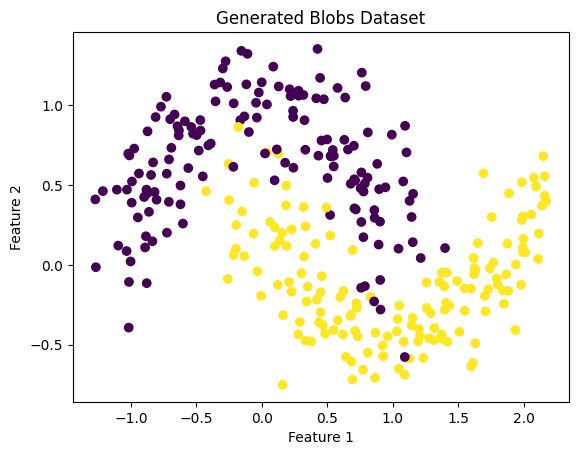

In [3]:
X, y = make_moons(n_samples=300, random_state = 3, noise = 0.18)
plt.scatter(X[:, 0], X[:, 1], c = y)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Generated Blobs Dataset")
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 12)

scaler = MinMaxScaler(feature_range=(-100,100))
X_train_minmax = scaler.fit_transform(X_train)
X_test_minmax = scaler.transform(X_test)

In [16]:
model = OptimizedPyTorchGradientSMPA(
    learning_rate=0.1,        # Moderate step size for gradient updates
    epochs=300,                # Enough iterations to converge
    random_state=11,           # Reproducibility
    verbose=True,              # Track progress
    lambda_reg=0.000001,           # Light regularization to prevent wild spline jumps
    patience=10,                # Standard patience for LR decay
    decay_factor=0.99,
    min_learning_rate=1e-6,    # Stop when LR gets tiny
    n_control_points=7,        # Flexible but not overkill
    track_history=True
)

In [18]:
model.fit(X_train_minmax, y_train)

Epoch 0: Errors = 47, LR = 0.100000
Epoch 5: Errors = 46, LR = 0.100000
Epoch 10: Errors = 45, LR = 0.100000
Epoch 15: Errors = 45, LR = 0.100000
Epoch 20: Errors = 44, LR = 0.100000
Epoch 25: Errors = 44, LR = 0.100000
Epoch 30: Errors = 44, LR = 0.099000
Epoch 35: Errors = 43, LR = 0.099000
Epoch 40: Errors = 42, LR = 0.099000
Epoch 45: Errors = 42, LR = 0.099000
Epoch 50: Errors = 42, LR = 0.098010
Epoch 55: Errors = 41, LR = 0.098010
Epoch 60: Errors = 38, LR = 0.098010
Epoch 65: Errors = 36, LR = 0.098010
Epoch 70: Errors = 35, LR = 0.098010
Epoch 75: Errors = 35, LR = 0.098010
Epoch 80: Errors = 34, LR = 0.098010
Epoch 85: Errors = 34, LR = 0.098010
Epoch 90: Errors = 32, LR = 0.098010
Epoch 95: Errors = 32, LR = 0.098010
Epoch 100: Errors = 31, LR = 0.098010
Epoch 105: Errors = 31, LR = 0.098010
Epoch 110: Errors = 30, LR = 0.098010
Epoch 115: Errors = 30, LR = 0.098010
Epoch 120: Errors = 30, LR = 0.098010
Epoch 125: Errors = 30, LR = 0.097030
Epoch 130: Errors = 29, LR = 0.097

OptimizedPyTorchGradientSMPA(decay_factor=0.99, device='cpu', epochs=300,
                             lambda_reg=1e-06, learning_rate=0.1,
                             n_control_points=7, random_state=11,
                             track_history=True, verbose=True)

In [19]:
from sklearn.metrics import classification_report

In [20]:
print("\nClassification Report:")
print(classification_report(y_test,model.predict(X_test_minmax)))
cr = classification_report(y_test, model.predict(X_test_minmax))


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        28
           1       0.94      0.94      0.94        32

    accuracy                           0.93        60
   macro avg       0.93      0.93      0.93        60
weighted avg       0.93      0.93      0.93        60



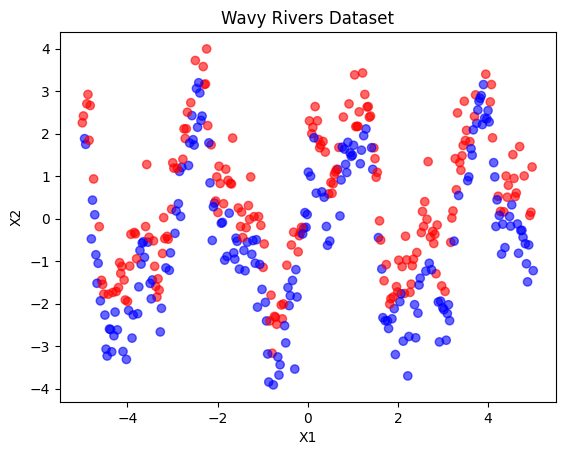

In [42]:
import numpy as np
import matplotlib.pyplot as plt

def generate_wavy_rivers(n_samples=400, noise=0.2, random_state=11):
    """
    Generate a 2D dataset with two classes separated by a squiggly, single-valued boundary.

    Parameters:
    - n_samples: Total number of points (split evenly between classes)
    - noise: Amount of random perturbation
    - random_state: Seed for reproducibility

    Returns:
    - X: 2D array of shape (n_samples, 2)
    - y: Labels array of shape (n_samples,)
    """
    np.random.seed(random_state)
    n_per_class = n_samples // 2

    # Generate x values
    x = np.linspace(-5, 5, n_samples)
    np.random.shuffle(x)
    x_class0 = x[:n_per_class]
    x_class1 = x[n_per_class:]

    # Define a squiggly boundary function (single-valued)
    boundary = (np.sin(2 * x) + 0.5 * np.cos(5 * x) + 0.3 * np.sin(10 * x)) * 2

    # Class 0: Points below the boundary with noise
    y_class0 = boundary[:n_per_class] - np.abs(np.random.normal(0, noise + 0.5, n_per_class))

    # Class 1: Points above the boundary with noise
    y_class1 = boundary[n_per_class:] + np.abs(np.random.normal(0, noise + 0.5, n_per_class))

    # Combine into dataset
    X = np.vstack([
        np.column_stack([x_class0, y_class0]),
        np.column_stack([x_class1, y_class1])
    ])
    y = np.hstack([np.zeros(n_per_class), np.ones(n_per_class)])

    # Shuffle
    perm = np.random.permutation(n_samples)
    X = X[perm]
    y = y[perm]

    return X, y

# Test it
X, y = generate_wavy_rivers(n_samples=400, noise=0.2)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.6)
plt.title("Wavy Rivers Dataset")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123)

scaler = MinMaxScaler(feature_range=(-100,100))
X_train_minmax = scaler.fit_transform(X_train)
X_test_minmax = scaler.transform(X_test)

In [44]:
model = OptimizedPyTorchGradientSMPA(
    learning_rate=0.5,        # Moderate step size for gradient updates
    epochs=400,                # Enough iterations to converge
    random_state=11,           # Reproducibility
    verbose=True,              # Track progress
    lambda_reg=0.000001,           # Light regularization to prevent wild spline jumps
    patience=15,                # Standard patience for LR decay
    decay_factor=0.9,
    min_learning_rate=1e-6,    # Stop when LR gets tiny
    n_control_points=8,        # Flexible but not overkill
    track_history=True
)

In [45]:
model.fit(X_train_minmax, y_train)

Epoch 0: Errors = 120, LR = 0.500000
Epoch 5: Errors = 121, LR = 0.500000
Epoch 10: Errors = 117, LR = 0.500000
Epoch 15: Errors = 116, LR = 0.500000
Epoch 20: Errors = 117, LR = 0.500000
Epoch 25: Errors = 114, LR = 0.500000
Epoch 30: Errors = 113, LR = 0.500000
Epoch 35: Errors = 114, LR = 0.500000
Epoch 40: Errors = 114, LR = 0.500000
Epoch 45: Errors = 115, LR = 0.500000
Epoch 50: Errors = 113, LR = 0.450000
Epoch 55: Errors = 112, LR = 0.450000
Epoch 60: Errors = 117, LR = 0.450000
Epoch 65: Errors = 115, LR = 0.450000
Epoch 70: Errors = 113, LR = 0.450000
Epoch 75: Errors = 110, LR = 0.405000
Epoch 80: Errors = 110, LR = 0.405000
Epoch 85: Errors = 109, LR = 0.405000
Epoch 90: Errors = 108, LR = 0.405000
Epoch 95: Errors = 105, LR = 0.405000
Epoch 100: Errors = 105, LR = 0.405000
Epoch 105: Errors = 103, LR = 0.405000
Epoch 110: Errors = 103, LR = 0.405000
Epoch 115: Errors = 102, LR = 0.405000
Epoch 120: Errors = 101, LR = 0.405000
Epoch 125: Errors = 97, LR = 0.405000
Epoch 130

OptimizedPyTorchGradientSMPA(device='cpu', epochs=400, lambda_reg=1e-06,
                             learning_rate=0.5, n_control_points=8, patience=15,
                             random_state=11, track_history=True, verbose=True)

In [46]:
print("\nClassification Report:")
print(classification_report(y_test,model.predict(X_test_minmax)))
cr = classification_report(y_test, model.predict(X_test_minmax))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.74      0.66        38
         1.0       0.70      0.55      0.61        42

    accuracy                           0.64        80
   macro avg       0.65      0.64      0.64        80
weighted avg       0.65      0.64      0.63        80



In [53]:
import matplotlib.pyplot as plt

def plot_smpa_convergence(model, figsize=(10, 4), title="SMPA Error Convergence"):
    if not hasattr(model, 'track_history') or not model.track_history or not hasattr(model, 'error_history_'):
        print("Error: Model must have track_history=True and be fitted with error_history_ recorded.")
        return None

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(model.error_history_, 'b-', label='Errors')
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Number of Errors')
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    return fig

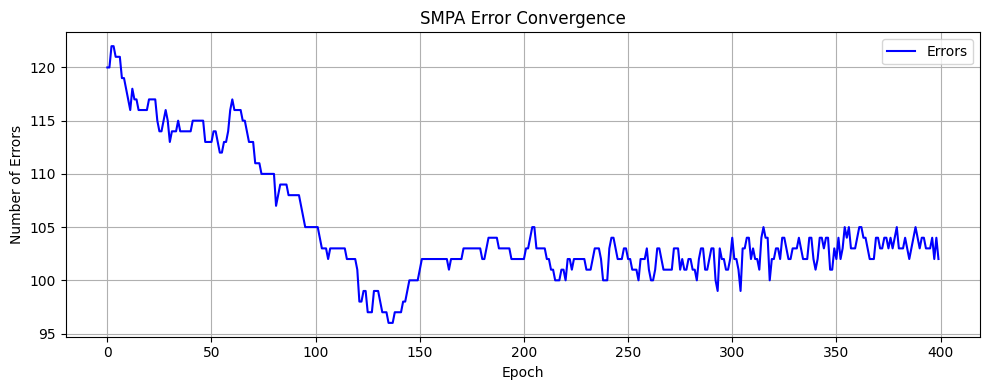

In [54]:
fig = plot_smpa_convergence(model)
plt.show()

In [47]:
from sklearn.preprocessing import StandardScaler

In [48]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [49]:
from sklearn.model_selection import GridSearchCV

In [50]:
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'kernel': ['rbf']  # Explicitly set to 'rbf'
}

# Create an instance of SVM
svm = SVC(random_state=4)

# Instantiate the GridSearchCV object:
# - 'svm' is the estimator
# - 'param_grid' defines the parameters to try
# - 'cv=5' means 5-fold cross-validation
# - 'scoring='accuracy'' uses accuracy to compare model performance
# - 'n_jobs=-1' uses all processors for computation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit GridSearchCV to find the best parameters
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best cross-validation score: {:.2f}".format(best_score))

# Evaluate the best model on the test set
best_model_new = grid_search.best_estimator_
test_score = best_model_new.score(X_test, y_test)
print("Test set score with best model: {:.2f}".format(test_score))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.64
Test set score with best model: 0.45


In [51]:
print("\nClassification Report:")
print(classification_report(y_test, best_model_new.predict(X_test_scaled)))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.53      0.55      0.54        38
         1.0       0.57      0.55      0.56        42

    accuracy                           0.55        80
   macro avg       0.55      0.55      0.55        80
weighted avg       0.55      0.55      0.55        80



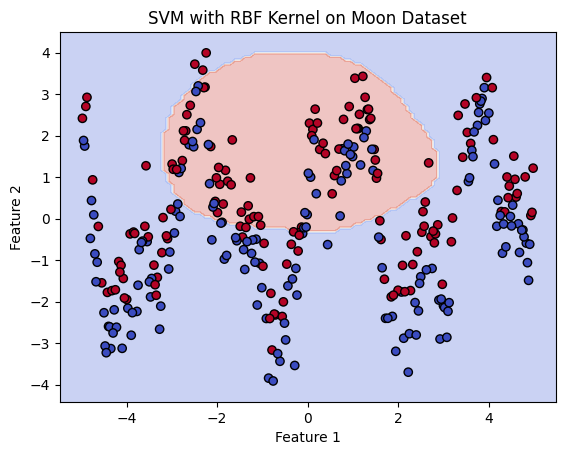

In [52]:
xx, yy = np.meshgrid(np.linspace(X_train[:,0].min()-0.5, X_train[:,0].max()+0.5, 100),
                     np.linspace(X_train[:,1].min()-0.5, X_train[:,1].max()+0.5, 100))
Z = best_model_new.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='coolwarm', edgecolors='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("SVM with RBF Kernel on Moon Dataset")
plt.show()

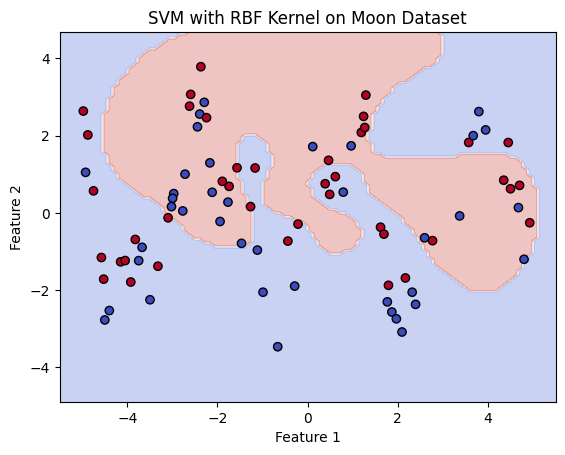

In [28]:
xx, yy = np.meshgrid(np.linspace(X_train[:,0].min()-0.5, X_train[:,0].max()+0.5, 100),
                     np.linspace(X_train[:,1].min()-0.5, X_train[:,1].max()+0.5, 100))
Z = best_model_new.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap='coolwarm', edgecolors='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("SVM with RBF Kernel on Moon Dataset")
plt.show()

In [56]:
import numpy as np

def generate_toy_dataset(n_samples=1000, random_state=7):
    # Set random seed for reproducibility
    np.random.seed(random_state)

    # Generate 3 predictive features
    x1 = np.random.uniform(-1, 1, n_samples)
    x2 = np.random.uniform(-1, 1, n_samples)
    x3 = np.random.uniform(-1, 1, n_samples)

    # Compute response variable with interactions and non-linearity
    X_last = x1 * x2 + np.sin(np.pi * x3) + np.random.normal(0, 0.1, n_samples)

    # Combine into feature matrix (x1, x2, x3, X_last)
    X = np.column_stack([x1, x2, x3, X_last])

    # Generate labels based on X_last threshold (median for balanced classes)
    threshold = np.median(X_last)
    y = (X_last > threshold).astype(int)

    return X, y

# Generate dataset
X, y = generate_toy_dataset(n_samples=1000, random_state=7)

# Verify dataset
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Class balance:", np.bincount(y))
print("X[:, -1] range:", X[:, -1].min(), X[:, -1].max())
print("Feature ranges:", X[:, :-1].min(axis=0), X[:, :-1].max(axis=0))

X shape: (1000, 4)
y shape: (1000,)
Class balance: [500 500]
X[:, -1] range: -1.9276860663104305 1.9406380647122043
Feature ranges: [-0.99963016 -0.99710631 -0.99588175] [0.99946603 0.99601529 0.9995589 ]


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=21)

In [58]:
model = OptimizedPyTorchGradientSMPA(
    learning_rate=0.5,        # Moderate step size for gradient updates
    epochs=400,                # Enough iterations to converge
    random_state=11,           # Reproducibility
    verbose=True,              # Track progress
    lambda_reg=0.000001,           # Light regularization to prevent wild spline jumps
    patience=15,                # Standard patience for LR decay
    decay_factor=0.9,
    min_learning_rate=1e-6,    # Stop when LR gets tiny
    n_control_points=8,        # Flexible but not overkill
    track_history=True
)

model.fit(X_train, y_train)

Epoch 0: Errors = 38, LR = 0.500000
Epoch 5: Errors = 56, LR = 0.500000
Epoch 10: Errors = 48, LR = 0.500000
Epoch 15: Errors = 56, LR = 0.500000
Epoch 20: Errors = 25, LR = 0.450000
Epoch 25: Errors = 28, LR = 0.450000
Epoch 30: Errors = 30, LR = 0.450000
Epoch 35: Errors = 19, LR = 0.450000
Epoch 40: Errors = 15, LR = 0.450000
Epoch 45: Errors = 22, LR = 0.450000
Epoch 50: Errors = 24, LR = 0.450000
Epoch 55: Errors = 17, LR = 0.450000
Epoch 60: Errors = 17, LR = 0.450000
Epoch 65: Errors = 16, LR = 0.450000
Epoch 70: Errors = 25, LR = 0.405000
Epoch 75: Errors = 16, LR = 0.405000
Epoch 80: Errors = 18, LR = 0.405000
Epoch 85: Errors = 15, LR = 0.405000
Epoch 90: Errors = 27, LR = 0.405000
Epoch 95: Errors = 13, LR = 0.364500
Epoch 100: Errors = 20, LR = 0.364500
Epoch 105: Errors = 23, LR = 0.364500
Epoch 110: Errors = 15, LR = 0.328050
Epoch 115: Errors = 12, LR = 0.328050
Epoch 120: Errors = 9, LR = 0.328050
Epoch 125: Errors = 13, LR = 0.295245
Epoch 130: Errors = 19, LR = 0.2952

OptimizedPyTorchGradientSMPA(device='cpu', epochs=400, lambda_reg=1e-06,
                             learning_rate=0.5, n_control_points=8, patience=15,
                             random_state=11, track_history=True, verbose=True)

In [59]:
print(f"Training accuracy: {model.score(X_train, y_train)}")
print(f"Test accuracy: {model.score(X_test, y_test)}")

Training accuracy: 1.0
Test accuracy: 0.99
